In [1]:
'''=============================================================
===================== SECTION IMPORTS ==========================
================================================================'''
from time import time

# General imports
import pandas as pd
import numpy as np
import sklearn.base
from numpy import logspace, linspace
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, ElasticNetCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RandomizedSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Defines the path to the dataset folder
your_datapath = '../data/ZHL/'
#district_name = "Afgooye" #Adan Yabaal, Afgooye, Afmadow

# new features data path
acled_datapath = '../data/acled/'


In [3]:
# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

## Function Definations

In [4]:
# Function that creates a pandas dataframe for a single district with columns for the baseline model with semi-yearly entries
def make_district_df_semiyearly(datapath, acled_datapath, district_name):

    """
    Function that creates a pandas dataframe for a single district with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder
    district_name : string
        Name of the district

    Returns
    -------
    df : pandas dataframe
    """

    # Read all relevant datasets
    prevalence_df = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    covid_df = pd.read_csv(datapath + 'covid.csv', parse_dates=['date'])
    ipc_df = pd.read_csv(datapath + 'ipc2.csv', parse_dates=['date'])
    risk_df = pd.read_csv(datapath + 'FSNAU_riskfactors.csv', parse_dates=['date'])
    production_df = pd.read_csv(datapath + 'production.csv', parse_dates=['date'])
    # updated code dc3
    conflict_df = pd.read_csv(acled_datapath + 'acled_features.csv', parse_dates=['date'])


    # Select data for specific district
    prevalence_df = prevalence_df[prevalence_df['district'] == district_name]
    ipc_df = ipc_df[ipc_df['district'] == district_name]
    risk_df = risk_df[risk_df['district'] == district_name]
    production_df = production_df[production_df['district'] == district_name]
    # updated code dc3
    conflict_df = conflict_df[conflict_df['district'] == district_name].copy()
    conflict_df.drop(columns=['district'],inplace=True)



    risk_df = risk_df.groupby(pd.Grouper(key='date', freq='6M')).mean()
    risk_df = risk_df.reset_index()
    risk_df['date'] = risk_df['date'].apply(lambda x: x.replace(day=1))

    covid_df = covid_df.groupby(pd.Grouper(key='date', freq='6M')).sum()
    covid_df = covid_df.reset_index()
    covid_df['date'] = covid_df['date'].apply(lambda x: x.replace(day=1))

    production_df['cropdiv'] = production_df.count(axis=1)

    # Sort dataframes on date
    prevalence_df.sort_values('date', inplace=True)
    covid_df.sort_values('date', inplace=True)
    ipc_df.sort_values('date', inplace=True)
    risk_df.sort_values('date', inplace=True)
    production_df.sort_values('date', inplace=True)
    # updated code dc3
    conflict_df.sort_values('date', inplace=True)


    # Merge dataframes, only joining on current or previous dates as to prevent data leakage
    df = pd.merge_asof(left=prevalence_df, right=ipc_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=production_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=risk_df, direction='backward', on='date')
    df = pd.merge_asof(left=df, right=covid_df, direction='backward', on='date')
    # updated code dc3 
    df = pd.merge_asof(left=df, right=conflict_df, direction='backward', on='date')


    # Calculate prevalence 6lag
    df['prevalence_6lag'] = df['GAM Prevalence'].shift(1)
    df['next_prevalence'] = df['GAM Prevalence'].shift(-1)

    # # Select needed columns
    # df = df[['date', 'district_x', 'GAM Prevalence', 'next_prevalence', 'prevalence_6lag', 'new_cases', 'ndvi_score',
    #          'phase3plus_perc', 'cropdiv', 'total population']]
    # df.columns = ['date', 'district', 'prevalence', 'next_prevalence', 'prevalence_6lag', 'covid', 'ndvi', 'ipc',
    #               'cropdiv', 'population']

    # updated code dc3
    conflict_cols = conflict_df.columns.to_list()[1:]
    df = df[['date', 'district_x', 'GAM Prevalence', 'next_prevalence', 'prevalence_6lag', 'new_cases', 'ndvi_score',
             'phase3plus_perc', 'cropdiv', 'total population'] + conflict_cols ]
    df.columns = ['date', 'district', 'prevalence', 'next_prevalence', 'prevalence_6lag', 'covid', 'ndvi', 'ipc',
                  'cropdiv', 'population'] + conflict_cols


    # Add month column
    df['month'] = df['date'].dt.month

    # Add target variable: increase for next month prevalence (boolean)
    increase = [False if x[1] < x[0] else True for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase.append(False)
    df['increase'] = increase
    df.iloc[-1, df.columns.get_loc('increase')] = np.nan  # No info on next month

    # Add target variable: increase for next month prevalence (boolean)
    increase_numeric = [x[1] - x[0] for x in list(zip(df['prevalence'], df['prevalence'][1:]))]
    increase_numeric.append(0)
    df['increase_numeric'] = increase_numeric
    df.iloc[-1, df.columns.get_loc('increase_numeric')] = np.nan  # No info on next month

    df.loc[(df.date < pd.to_datetime('2020-03-01')), 'covid'] = 0

    return (df)

In [5]:
# Function that combines the semiyearly dataset (from the function make_district_df_semiyearly) of all districts
def make_combined_df_semiyearly(datapath,acled_datapath):
    """
    Function that creates a pandas dataframe for all districts with columns for the baseline model with semiyearly entries

    Parameters
    ----------
    datapath : string
        Path to the datafolder

    Returns
    -------
    df : pandas dataframe
    """

    prevdf = pd.read_csv(datapath + 'prevalence_estimates.csv', parse_dates=['date'])
    districts = prevdf['district'].unique()

    df_list = []
    for district in districts:
        district_df = make_district_df_semiyearly(datapath, acled_datapath, district)
        district_df['district'] = district
        df_list.append(district_df)

    df = pd.concat(df_list, ignore_index=True)
    df['district_encoded'] = df['district'].astype('category').cat.codes

    return df

In [6]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l):
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

## =================================================================================================
## MAIN FUNCTION

In [7]:
# Create the dataframe for all districts
df = make_combined_df_semiyearly(your_datapath,acled_datapath)
df

,date,district,prevalence,next_prevalence,prevalence_6lag,covid,ndvi,ipc,cropdiv,population,...,inter_3,inter_4,inter_5,inter_6,inter_7,inter_8,month,increase,increase_numeric,district_encoded
0,2017-07-01,Adan Yabaal,0.369200,0.351000,NaN,0.0,0.215000,NaN,2.0,6.526296e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,7,False,-0.018200,2
1,2018-01-01,Adan Yabaal,0.351000,0.278939,0.369200,0.0,0.225000,NaN,4.0,6.526296e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,1,False,-0.072061,2
2,2018-07-01,Adan Yabaal,0.278939,0.395974,0.351000,0.0,0.260000,NaN,4.0,3.785915e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,7,True,0.117034,2
3,2019-01-01,Adan Yabaal,0.395974,0.340623,0.278939,0.0,0.273333,NaN,4.0,3.785915e+04,...,0.0,0.0,0.0,0.0,0.0,0.0,1,False,-0.055351,2
4,2019-07-01,Adan Yabaal,0.340623,0.312611,0.395974,0.0,0.246667,NaN,3.0,3.785915e+04,...,1.0,1.0,0.0,0.0,3.0,0.0,7,False,-0.028011,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,2017-07-01,Ceel barde,0.486200,0.486200,NaN,0.0,NaN,NaN,NaN,4.607096e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,7,True,0.000000,41
673,2018-01-01,Ceel barde,0.486200,NaN,0.486200,0.0,NaN,NaN,NaN,4.607096e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,41
674,2017-07-01,Mogadishu,0.389306,0.291200,NaN,0.0,NaN,NaN,NaN,2.077274e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,7,False,-0.098106,68
675,2018-01-01,Mogadishu,0.291200,NaN,0.389306,0.0,NaN,NaN,NaN,1.707985e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,68


In [8]:
print("Total no of district before droping are - ",len(df['district'].value_counts().keys()))

Total no of district before droping are -  87


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prevalence,677.0,0.376678,0.097403,0.091189,0.312611,0.384560,0.445262,6.739054e-01
next_prevalence,590.0,0.370835,0.100112,0.091189,0.301844,0.379337,0.445031,6.739054e-01
prevalence_6lag,590.0,0.378064,0.098194,0.091189,0.315132,0.384463,0.446185,6.480009e-01
covid,677.0,1245.867061,2554.983520,0.000000,0.000000,0.000000,5.000000,7.810000e+03
ndvi,629.0,0.264661,0.115720,0.000000,0.173333,0.235000,0.343333,6.100000e-01
ipc,600.0,0.132433,0.106511,0.000000,0.060000,0.110000,0.170000,5.800000e-01
cropdiv,350.0,5.180000,1.905850,2.000000,4.000000,5.000000,6.000000,1.000000e+01
population,603.0,167638.360262,253802.381375,14000.000000,64346.000000,99157.000000,180166.419425,2.228463e+06
fatalities,636.0,29.268868,58.664521,0.000000,0.000000,6.000000,31.000000,4.930000e+02
event_type_Battles,636.0,8.232704,19.432887,0.000000,0.000000,2.000000,7.000000,1.880000e+02


- here we have 677 data points
- the cropdiv has only 350 data points, so if we use directly use dropna (dropping values with NaN), the data points will be below 350 of course because we have NaN values for those crop diversity  

In [10]:
# Drop every row with missing values
df.dropna(inplace=True)

In [11]:
# Sort dataframe on date and reset the index
df.sort_values('date', inplace=True)
df.reset_index(inplace=True, drop=True)

In [12]:
# Drop districts with less than 7 observations: 'Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'
df.drop(df[df['district'].isin(['Burco', 'Saakow', 'Rab Dhuure', 'Baydhaba', 'Afmadow'])].index, inplace=True)

In [13]:
print("Total no of district after droping are - ",len(df['district'].value_counts().keys()))

Total no of district after droping are -  33


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prevalence,231.0,0.382090,0.107469,0.127787,0.307242,0.392600,0.462371,6.480009e-01
next_prevalence,231.0,0.385322,0.106224,0.127787,0.306104,0.406036,0.461843,6.480009e-01
prevalence_6lag,231.0,0.390581,0.099032,0.127787,0.343341,0.397141,0.460567,6.480009e-01
covid,231.0,512.571429,1256.220443,0.000000,0.000000,0.000000,5.000000,3.583000e+03
ndvi,231.0,0.336782,0.117886,0.000000,0.250833,0.326667,0.426667,6.100000e-01
ipc,231.0,0.085758,0.073439,0.000000,0.030000,0.080000,0.120000,4.200000e-01
cropdiv,231.0,5.281385,1.914146,2.000000,4.000000,5.000000,6.000000,1.000000e+01
population,231.0,157535.571146,175293.997359,20212.000000,69575.061686,101133.000000,183233.500000,1.044086e+06
fatalities,231.0,38.913420,60.479758,0.000000,1.500000,14.000000,52.000000,4.120000e+02
event_type_Battles,231.0,10.060606,16.572260,0.000000,1.000000,3.000000,12.000000,1.230000e+02


- So after dropping we are left with only 231 data points
- just because of one cropdiv column (350 values) we removed all the other informations from the data because of **dropna**, which does not make sense, either missing values should be computed or the column should have been dropped, similarly fot ipc classification

**NOTE** 

    - becuase of the above approach we are loosing a lot of information (63% of the data), so even if we make new changes (model/data), it may be possible that changes are not reflected because of this limited amount of data points

### ===========================================================================================
### RANDOM FOREST CROSS VALIDATION

In [15]:
# (Below Explanation is taken from "baseline_mod.py" ( Adma & TJ ) )
################################################################
# How the original model building works

################################################################
# The first 2 nested for loops will try all the different sizes of random forest
# Within the innermost nest for loop (for features in subsets(X.columns)), the RF is
# trying every single combination of features that are available in the dataframe.

# The cross validation is done by calling X[:99]. In this case, the data is ordered by date, and they know already
# that there are 33 unique districts, so they use a multiple of 33 whenever doing cross-validation. So here,
# they use rows 1-99 to train (first 3 observations) and the next 33 rows (100-132, the 4th observation) to test.
# They do this again for a second CV using the first 4 observations to train, and the 5th to test.
# This approach removes the temporality of the data. It essentially creates 2 models: 1 based on the first 3
# observations (CV-1), and one on the first 4 observations (CV-2), and then combines those two models as a final.
# Since the data is sorted by date before being used, this has some naive temporality as it is using the oldest data
# for training and the most recent data for testing. However, there is no differentiation between the relevance of how
# far back data goes (e.g. it is not a time series!).
# ###############################################################

In [90]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
#WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

#Create empty list to store model scores
parameter_scores = []

#Define target and explanatory variables
X = df.drop(columns = ['increase', 'increase_numeric', 'date', 'district', 'prevalence', 'next_prevalence']) #Note that these columns are dropped, the remaining columns are used as explanatory variables
y = df['next_prevalence'].values

In [91]:
#### ===================================================================================================
# since we can not run the code on all possible combinations (1000+ models), this is computationally infeasible,
# so we kept the best feature found out by baseline model + our top n features from conflict data (total 8 features) to run over all the combinations
# tried with the below combinations, and district_encoded was still the best feaature to be used, hence no improvment from any of the combinations of our important features
# Index(['inter_2', 'inter_1', 'event_type_Battles', 'fatalities', 'inter_3',
#        'inter_8', 'event_type_Explosions/Remote violence'] + ['district_encoded]
#       dtype='object')



#### ==============================================
# The below code to reproduce the same columns as mentioned above

# # select top n features from conflict data
# top_n = 7

# # extracted the conflicts data out
# conflicts_X = X.iloc[:,6:-2]

# # fit random forest to identify the best features
# clf = RandomForestRegressor(random_state=0)
# clf.fit(conflicts_X, y)

# # calculate feature importance
# feat_importances = pd.Series(clf.feature_importances_, index= conflicts_X.columns)

# # to plot the feature importance
# # plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
# # feat_importances.nlargest(15).plot(kind='barh')


# top_n_cols = feat_importances.sort_values(ascending=False).keys()[:top_n]
# # top_n_cols

# # selected features
# feature_ls = ['district_encoded'] + top_n_cols.to_list()

In [92]:
# model training and selection
# # selected features
# feature_ls = ['district_encoded'] + top_n_cols.to_list()
features = X.columns

for num_trees in range(num_trees_min, num_trees_max):
    
    for depth in range(depth_min, depth_max):
        
        #Investigate every subset of explanatory variables
        # for features in subsets(feature_ls):
            
        #First CV split. The 99 refers to the first 3 observations for the 33 districts in the data.
        Xtrain = X[:99][features].copy().values
        ytrain = y[:99]
        Xtest = X[99:132][features].copy().values
        ytest = y[99:132]

        #Create a RandomForestRegressor with the selected hyperparameters and random state 0.
        clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

        #Fit to the training data
        clf.fit(Xtrain, ytrain)

        #Make a prediction on the test data
        predictions = clf.predict(Xtest)

        #Calculate mean absolute error
        MAE1 = mean_absolute_error(ytest, predictions)


        #Second CV split. The 132 refers to the first 4 observations for the 33 districts in the data.
        Xtrain = X[:132][features].copy().values
        ytrain = y[:132]
        Xtest = X[132:165][features].copy().values
        ytest = y[132:165]

        #Create a RandomForestRegressor with the selected hyperparameters and random state 0.
        clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0)

        #Fit to the training data
        clf.fit(Xtrain, ytrain)

        #Make a prediction on the test data
        predictions = clf.predict(Xtest)

        #Calculate mean absolute error
        MAE2 = mean_absolute_error(ytest, predictions)

        #Calculate the mean MAE over the two folds
        mean_MAE = (MAE1 + MAE2)/2

        #Store the mean MAE together with the used hyperparameters in list 
        parameter_scores.append((mean_MAE, num_trees, depth, features))


#Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

In [93]:
# # for baseline model
# print(best_model_score,best_model_trees,best_model_depth,best_model_columns)
# # 0.057504303030227646 74 6 ['district_encoded']
print(best_model_score,best_model_trees,best_model_depth,best_model_columns)

0.06231988330505752 72 6 ['prevalence_6lag', 'covid', 'ndvi', 'ipc', 'cropdiv', 'population', 'fatalities', 'event_type_Battles', 'event_type_Explosions/Remote violence', 'event_type_Protests', 'event_type_Riots', 'event_type_Strategic developments', 'event_type_Violence against civilians', 'inter_1', 'inter_2', 'inter_3', 'inter_4', 'inter_5', 'inter_6', 'inter_7', 'inter_8', 'month', 'district_encoded']


### SECTION FINAL EVALUATION

In [94]:
X = df[best_model_columns].values
y = df['next_prevalence'].values

#If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
	X = X.reshape(-1, 1)

#Peform evaluation on full data
Xtrain = X[:165]
ytrain = y[:165]
Xtest = X[165:]
ytest = y[165:]

In [95]:
clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

In [96]:
#Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

In [97]:
#Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase           = [0 if x<y else 1 for x in df.iloc[165:]['next_prevalence'] for y in df.iloc[165:]['prevalence']]
predicted_increase = [0 if x<y else 1 for x in predictions                      for y in df.iloc[165:]['prevalence']]

#Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

In [98]:
#Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(best_model_columns))

#Print model scores
print(MAE, acc)

# for the baseline model
# no. of trees: 74
# max_depth: 6
# columns: ['district_encoded']
# 0.05629900026844118 0.849862258953168

no. of trees: 72
max_depth: 6
columns: ['prevalence_6lag', 'covid', 'ndvi', 'ipc', 'cropdiv', 'population', 'fatalities', 'event_type_Battles', 'event_type_Explosions/Remote violence', 'event_type_Protests', 'event_type_Riots', 'event_type_Strategic developments', 'event_type_Violence against civilians', 'inter_1', 'inter_2', 'inter_3', 'inter_4', 'inter_5', 'inter_6', 'inter_7', 'inter_8', 'month', 'district_encoded']
0.05531697367217989 0.8399908172635445


## NEW Evaluation method


#### Baseline Evaluation Method ( MAE and Classification Accuracy )

**Issues**

1. Since it is a regression problem, classifing them as increased or decreased can give wrong estimation regarding the model. Here we are trying to predict the prevelence of wasted children, if the next prevelence increased by 0.0001 and the model preidcted that the prevelence is decreased by 0.0001 then even though the model is vary accurate and the difference between the original and prediction is 0.0002, it will be classified as wrong prediction, which is not correct measure at all.

2. Although MAE is a good measure of regression problem but it is unit dependent. So just by looking at the number we don't know if the model is good or bad for example say in a regression problem the target variable price is in millions then the error will be big, while when dealing with small scale output variable say height error will be small.


#### Proposed - Adjusted R^2

**What is Adjusted R^2 ?**
1. Adjusted R squared is a modified version of R square (Here basically we are compare how good is our model with respect to mean, if we have predicted mean always), and it is adjusted for the number of independent variables in the model, and it will always be less than or equal to R². R Squared value always increases with the addition of the independent variables which might lead to the addition of the redundant variables in our model. However, the adjusted R-squared solves this problem. because in R^2 as we add new variable the mean error will be more than predict so 1-(predict/mean) will always increase, so we balance the addition of new independent variable

**Why Adjusted R^2**

1. As explaind above, we need some regression metric which will be unit independent, so out of different regression metric [SSE, MSE, RMSE, MAE, MAPE, R^2, Adjusted R^2] we chose Adjusted R^2 as it is unit independent (not dependent on target variable, like classification where 80% accuracy is independent of what we are classifying), so provide  easier and correct analysis.

In [99]:
def model_evaluation(ytest, predictions, best_model_columns):
    #Calculate R^2
    R2 = abs(r2_score(ytest, predictions))

    # n = number of samples in test set
    n = len(ytest)

    # p = number of independent variables
    p = len(best_model_columns)

    # adjusted R^2 model
    Adjusted_R2 = 1 - ((1-R2) * (n-1)/(n-p-1))
    
    return R2, Adjusted_R2

In [100]:
# Calculate R^2 and adjusted R^2 model
# baseline model R^2 = 0.4075636387524749
# baseline model adjusted R^2 = 0.3983068206079824
R2, Adjusted_R2 = model_evaluation(ytest, predictions, best_model_columns)
print(f"The R^2 and and adjusted R^2 scores are as followes - \nR2 - {R2}  \nAdjusted R^2 - {Adjusted_R2}")

The R^2 and and adjusted R^2 scores are as followes - 
R2 - 0.3155336659013076  
Adjusted R^2 - -0.059293136105119215


### FINAL RESULTS ANALYSIS

**RESULTS**

1. Since all the combinations can not be trained in case of large number of features (1000+ subsets), we trained the model on all features (baseline + new)
2. The above model, reduced the MAE error but accuracy also goes down
3. On our new evaluation method, the accuracy decreased, and even indicating negative number, which showes the model is even worse than simply predicting mean


**ANALYSIS**

1. As Number of data points are less, including new features may not be helping to learn the model much, we may need to change the parameter space in order to fit the model with new features better.
2. As indicated in below graph, each district prevelence is quite different from each other, so with only one column district_encode model is able to predict the prevelnce quite well on the limited data points, (It may be not gernelized enough for future)

<AxesSubplot:xlabel='district_encoded', ylabel='next_prevalence'>

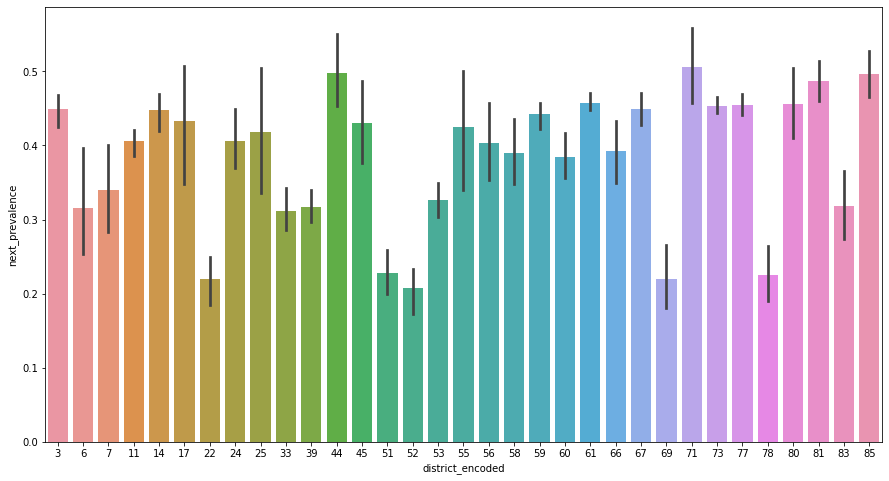

In [134]:
# the plot of baseline model best featrure against target variable
fig = plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.barplot(x='district_encoded' ,y='next_prevalence',data=df,ax=ax)